<a href="https://colab.research.google.com/github/surya81/Facial-key-point-detection/blob/main/facial_key_point_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset,DataLoader,Dataset
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import cluster
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6043, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6043 (delta 0), reused 1 (delta 0), pack-reused 6038
Receiving objects: 100% (6043/6043), 329.52 MiB | 29.49 MiB/s, done.
Resolving deltas: 100% (153/153), done.
Checking out files: 100% (5805/5805), done.


In [3]:
data.info

<bound method DataFrame.info of                        Unnamed: 0     0      1     2      3     4      5  \
0               Luis_Fonsi_21.jpg  45.0   98.0  47.0  106.0  49.0  110.0   
1           Lincoln_Chafee_52.jpg  41.0   83.0  43.0   91.0  45.0  100.0   
2           Valerie_Harper_30.jpg  56.0   69.0  56.0   77.0  56.0   86.0   
3             Angelo_Reyes_22.jpg  61.0   80.0  58.0   95.0  58.0  108.0   
4      Kristen_Breitweiser_11.jpg  58.0   94.0  58.0  104.0  60.0  113.0   
...                           ...   ...    ...   ...    ...   ...    ...   
3457       Thomas_Ferguson_02.jpg  35.0   94.0  35.0  105.0  38.0  112.0   
3458        Valerie_Harper_00.jpg  72.0  133.0  76.0  147.0  80.0  159.0   
3459          Maggie_Smith_00.jpg  52.0  149.0  56.0  160.0  63.0  168.0   
3460  Erin_Hershey_Presley_41.jpg  82.0   91.0  82.0  105.0  82.0  116.0   
3461     Rocco_Buttiglione_42.jpg  93.0  134.0  93.0  147.0  95.0  157.0   

          6      7      8  ...    126    127    128    

P1_Facial_Keypoints/data/training/Lincoln_Chafee_52.jpg
(196, 157, 3)


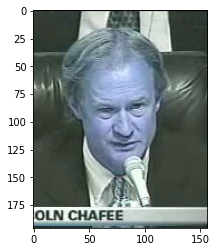

In [4]:
  img_path = 'P1_Facial_Keypoints/data/training/'+data.iloc[1,0]
  print(img_path)
  img = cv2.imread(img_path)/255
  plt.imshow(img)
  print(img.shape)


In [17]:
class FacesData(Dataset):
  def __init__(self,df):
    super(FacesData).__init__()
    self.df =df 
    self.normalize = transforms.Normalize(mean = [0.486,0.456,0.406],std =[0.229,0.224,0.225])
    
  def __len__(self):
    return len(self.df)

  def __getitem__(self,ix):
    img_path = 'P1_Facial_Keypoints/data/training/'+self.df.iloc[ix,0]
    img = cv2.imread(img_path)/255
    kp = deepcopy(self.df.iloc[ix,1:].tolist())
    kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
    kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
    kp2 = kp_x + kp_y
    kp2 = torch.tensor(kp2)
    img = self.preprocess_input(img)
    return img , kp2

  def preprocess_input(self, img ):
    img = cv2.resize(img,(224,224))
    img = torch.tensor(img).permute(2,0,1)
    img = self.normalize(img).float()
    return  img.to(device)

  def load_image(self,ix):
    img_path = img_path = 'P1_Facial_Keypoints/data/training/'+self.df.iloc[ix,0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)/255.
    img = cv2.resize(img,(224,224))
    return img



In [20]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(data,test_size = 0.2,random_state = 101)
train_dataset = FacesData(train.reset_index(drop = True))
test_dataset = FacesData(test.reset_index(drop = True))
train_loader = DataLoader(train_dataset,batch_size =32)
test_loader = DataLoader(test_dataset,batch_size =32)


In [21]:
def get_model():
  model = models.vgg16(pretrained =True )
  for param in model.parameters():
    param.requires_grad = False
  
  model.avgpool =nn.Sequential(
      nn.Conv2d(512,512,3),
      nn.MaxPool2d(2),
      nn.Flatten()
  )
  model.classifier = nn.Sequential(
      nn.Linear(2048,512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512,136),
      nn.Sigmoid(),
  )
  criterion = nn.L1Loss()
  optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
  return model.to(device),criterion,optimizer


In [22]:
model,criterion,optimizer = get_model()

In [23]:
def train_batch(img,kps,model,optimizer,criterion):
  model.train()
  optimizer.zero_grad()
  _kps = model(img.to(device))
  loss = criterion(_kps,kps.to(device))
  loss.backward()
  optimizer.step()
  return loss
  

In [24]:
def validate_batch(img,kps,model,criterion):
  model.eval()
  with torch.no_grad():
    _kps = model(img.to(device))
  loss  = criterion(_kps,kps.to(device))
  return _kps,loss


In [34]:
train_loss,test_loss = [],[]
n_epoch = 50 
for epoch in range(n_epoch):
  print(f"epoch {epoch+1}:50")
  epoch_train_loss,epoch_test_loss = 0,0 
  for ix , (img,kps) in enumerate(train_loader):
    loss = train_batch(img,kps,model,optimizer,criterion)
    epoch_train_loss += loss.item()
  epoch_train_loss /= (ix+1)
  for ix,(img,kps) in enumerate(test_loader):
    _kps,loss = validate_batch(img,kps,model,criterion)
    epoch_test_loss += loss.item() 
  epoch_test_loss /= (ix+1)
  train_loss.append(epoch_train_loss)
  test_loss.append(epoch_test_loss)


epoch 1:50
epoch 2:50
epoch 3:50
epoch 4:50
epoch 5:50
epoch 6:50
epoch 7:50
epoch 8:50
epoch 9:50
epoch 10:50
epoch 11:50
epoch 12:50
epoch 13:50
epoch 14:50
epoch 15:50
epoch 16:50
epoch 17:50
epoch 18:50
epoch 19:50
epoch 20:50
epoch 21:50
epoch 22:50
epoch 23:50
epoch 24:50
epoch 25:50
epoch 26:50
epoch 27:50
epoch 28:50
epoch 29:50
epoch 30:50
epoch 31:50
epoch 32:50
epoch 33:50
epoch 34:50
epoch 35:50
epoch 36:50
epoch 37:50
epoch 38:50
epoch 39:50
epoch 40:50
epoch 41:50
epoch 42:50
epoch 43:50
epoch 44:50
epoch 45:50
epoch 46:50
epoch 47:50
epoch 48:50
epoch 49:50
epoch 50:50


In [35]:
epochs = np.arange(50)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
% matplotlib inline



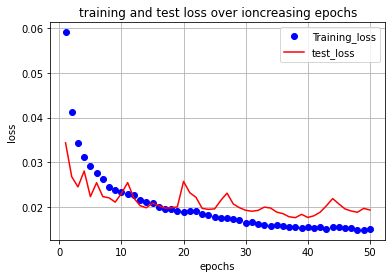

In [25]:
plt.plot(epochs,train_loss,'bo',label = 'Training_loss')
plt.plot(epochs,test_loss,'r',label = "test_loss")
plt.title('training and test loss over ioncreasing epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid('off')
plt.show()


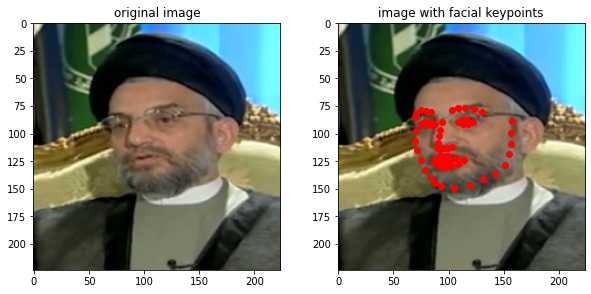

In [36]:
ix = 12
plt.figure(figsize = (10,10))
plt.subplot(221)
plt.title('original image')
im = test_dataset.load_image(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title("image with facial keypoints")
x,_ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224,kp[68:]*224,c='r')
plt.grid(False)
plt.show()